In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    top_k_accuracy_score
)
from pathlib import Path
from PIL import Image
import json
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device  : {device}")
print(f"   GPU    : {torch.cuda.get_device_name(0)}")


✅ Device  : cuda
   GPU    : NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [2]:
PROCESSED_DIR = Path("../datasets/processed")
MODELS_DIR    = Path("../models")
IMG_SIZE      = 224
BATCH_SIZE    = 32

# Class names load karo
with open(MODELS_DIR / "class_names.json") as f:
    class_names = json.load(f)
NUM_CLASSES = len(class_names)

# Model rebuild + weights load karo
def build_model(num_classes, device):
    model = models.efficientnet_b0(
        weights=None    # Random init — phr apne weights load karenge
    )
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.4, inplace=True),
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(512, num_classes)
    )
    return model.to(device)

model = build_model(NUM_CLASSES, device)
model.load_state_dict(
    torch.load(MODELS_DIR / "best_model.pth", map_location=device)
)
model.eval()

print(f"✅ Model loaded!")
print(f"   Classes : {NUM_CLASSES}")
print(f"   Weights : best_model.pth")


✅ Model loaded!
   Classes : 96
   Weights : best_model.pth


In [3]:
test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_dataset = datasets.ImageFolder(
    root=PROCESSED_DIR / "test",
    transform=test_transforms
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"✅ Test dataset loaded!")
print(f"   Images  : {len(test_dataset):,}")
print(f"   Batches : {len(test_loader)}")
print(f"   Classes : {len(test_dataset.classes)}")


✅ Test dataset loaded!
   Images  : 7,742
   Batches : 242
   Classes : 96


In [4]:
print("Running predictions on test set...")
print("=" * 45)

all_preds  = []
all_labels = []
all_probs  = []

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        
        outputs = model(images)
        probs   = torch.softmax(outputs, dim=1)
        _, preds = outputs.max(1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())
        
        if (batch_idx + 1) % 50 == 0:
            print(f"  Processed {(batch_idx+1)*BATCH_SIZE:,} images...")

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs  = np.array(all_probs)

# Top-1 and Top-5 accuracy
top1_acc = accuracy_score(all_labels, all_preds) * 100
top5_acc = top_k_accuracy_score(all_labels, all_probs, k=5) * 100

print(f"\n{'='*45}")
print(f"  Top-1 Accuracy : {top1_acc:.2f}%")
print(f"  Top-5 Accuracy : {top5_acc:.2f}%")
print(f"  Total images   : {len(all_labels):,}")
print(f"{'='*45}")

torch.cuda.empty_cache()


Running predictions on test set...
  Processed 1,600 images...
  Processed 3,200 images...
  Processed 4,800 images...
  Processed 6,400 images...

  Top-1 Accuracy : 91.75%
  Top-5 Accuracy : 99.66%
  Total images   : 7,742


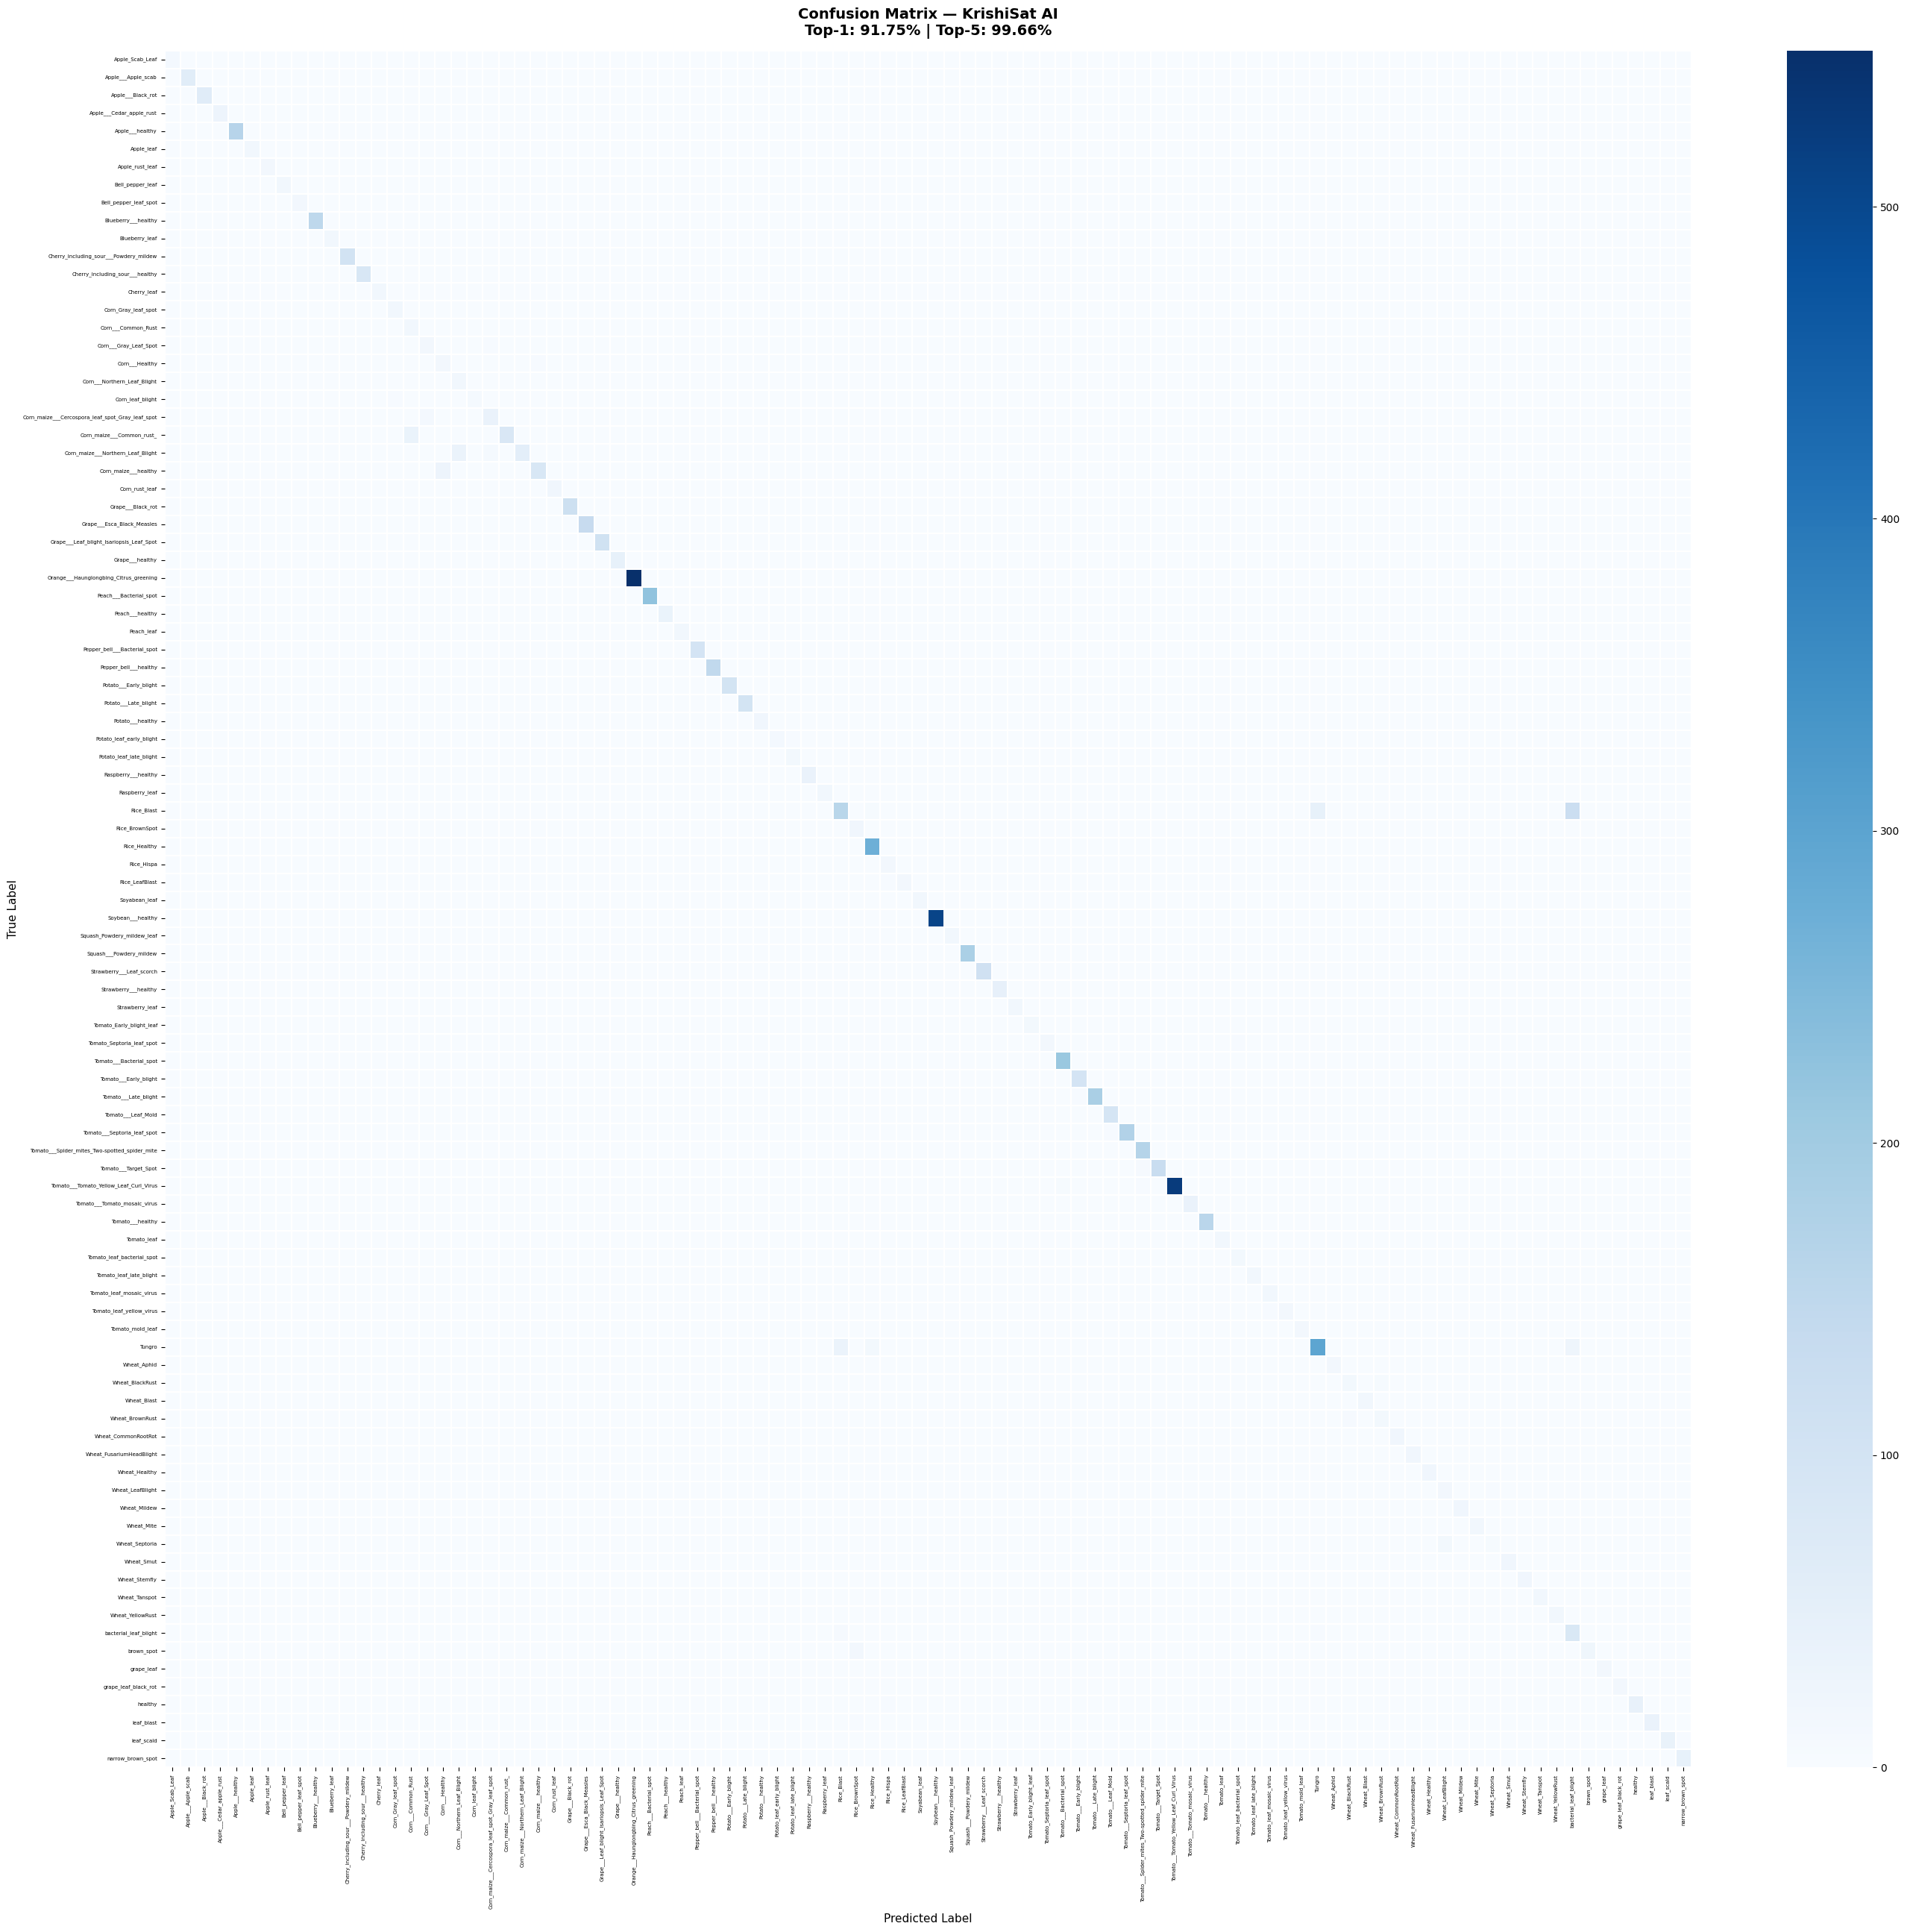

✅ Confusion matrix saved!


In [5]:
# Confusion matrix compute
cm = confusion_matrix(all_labels, all_preds)

# Plot (large figure — 96 classes hain)
fig, ax = plt.subplots(figsize=(28, 26))
sns.heatmap(
    cm,
    annot=False,          # 96x96 = too many numbers
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=0.1,
    ax=ax
)
ax.set_title(
    f"Confusion Matrix — KrishiSat AI\n"
    f"Top-1: {top1_acc:.2f}% | Top-5: {top5_acc:.2f}%",
    fontsize=14, fontweight='bold', pad=15
)
ax.set_xlabel("Predicted Label", fontsize=11)
ax.set_ylabel("True Label",      fontsize=11)
plt.xticks(rotation=90, fontsize=5)
plt.yticks(rotation=0,  fontsize=5)
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=150)
plt.show()

print("✅ Confusion matrix saved!")


In [6]:
# Classification report
report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    output_dict=True
)

# Print summary
print("PER-CLASS PERFORMANCE (sorted by F1 score)")
print("=" * 65)
print(f"{'Class':<40} {'Precision':>9} {'Recall':>7} {'F1':>7}")
print("-" * 65)

# F1 score ke hisaab se sort karo
sorted_classes = sorted(
    class_names,
    key=lambda x: report[x]["f1-score"],
    reverse=True
)

for cls in sorted_classes:
    p  = report[cls]["precision"] * 100
    r  = report[cls]["recall"]    * 100
    f1 = report[cls]["f1-score"]  * 100
    print(f"  {cls:<38} {p:>8.1f}% {r:>6.1f}% {f1:>6.1f}%")

print("=" * 65)
print(f"\n  Macro Avg F1    : {report['macro avg']['f1-score']*100:.2f}%")
print(f"  Weighted Avg F1 : {report['weighted avg']['f1-score']*100:.2f}%")


PER-CLASS PERFORMANCE (sorted by F1 score)
Class                                    Precision  Recall      F1
-----------------------------------------------------------------
  Apple___Cedar_apple_rust                  100.0%  100.0%  100.0%
  Blueberry___healthy                       100.0%  100.0%  100.0%
  Cherry_including_sour___healthy           100.0%  100.0%  100.0%
  Grape___Leaf_blight_Isariopsis_Leaf_Spot    100.0%  100.0%  100.0%
  Grape___healthy                           100.0%  100.0%  100.0%
  Potato___healthy                          100.0%  100.0%  100.0%
  Raspberry___healthy                       100.0%  100.0%  100.0%
  Squash___Powdery_mildew                   100.0%  100.0%  100.0%
  Strawberry___Leaf_scorch                  100.0%  100.0%  100.0%
  Strawberry___healthy                      100.0%  100.0%  100.0%
  Wheat_Healthy                             100.0%  100.0%  100.0%
  Wheat_Smut                                100.0%  100.0%  100.0%
  Soybean___health

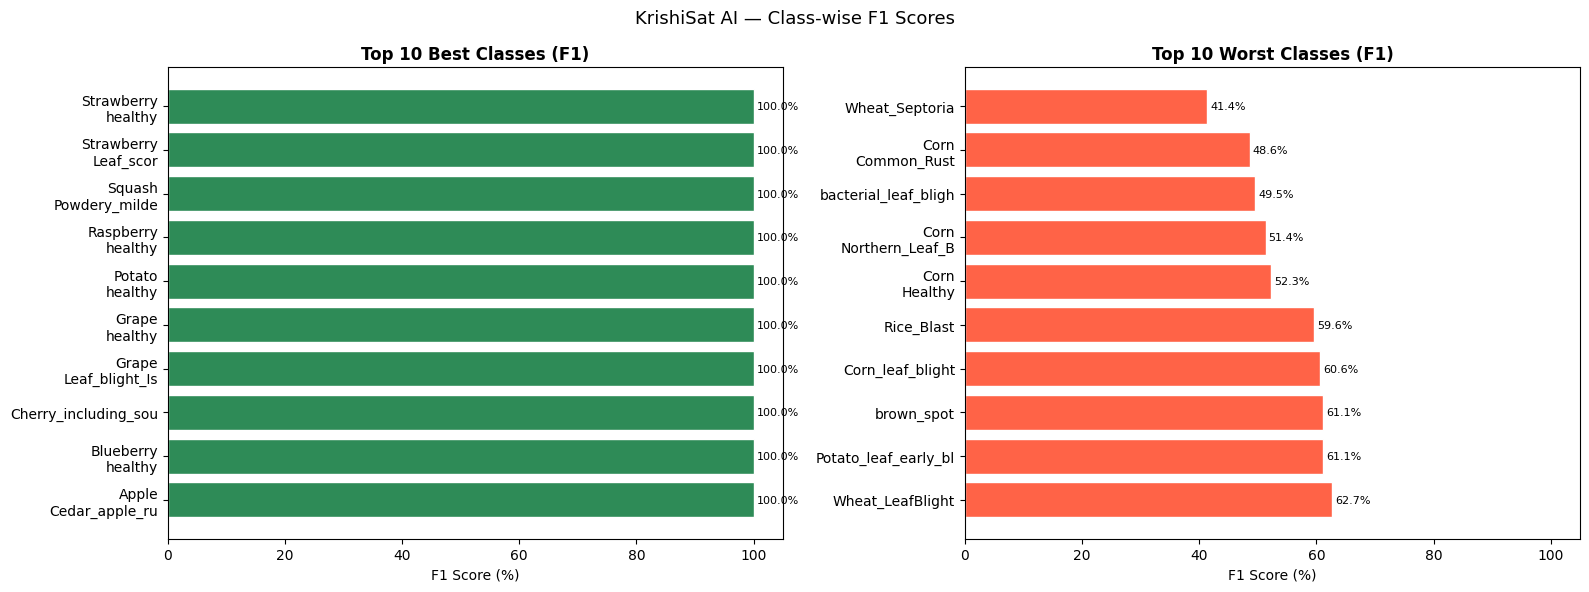

In [7]:
f1_scores = {cls: report[cls]["f1-score"] * 100 for cls in class_names}
sorted_f1 = sorted(f1_scores.items(), key=lambda x: x[1], reverse=True)

top10_best  = sorted_f1[:10]
top10_worst = sorted_f1[-10:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Best 10
names_b  = [c[0].replace("___", "\n")[:20] for c in top10_best]
scores_b = [c[1] for c in top10_best]
ax1.barh(names_b, scores_b, color='seagreen', edgecolor='white')
ax1.set_title("Top 10 Best Classes (F1)", fontsize=12, fontweight='bold')
ax1.set_xlabel("F1 Score (%)")
ax1.set_xlim(0, 105)
for i, v in enumerate(scores_b):
    ax1.text(v + 0.5, i, f"{v:.1f}%", va='center', fontsize=8)

# Worst 10
names_w  = [c[0].replace("___", "\n")[:20] for c in top10_worst]
scores_w = [c[1] for c in top10_worst]
ax2.barh(names_w, scores_w, color='tomato', edgecolor='white')
ax2.set_title("Top 10 Worst Classes (F1)", fontsize=12, fontweight='bold')
ax2.set_xlabel("F1 Score (%)")
ax2.set_xlim(0, 105)
for i, v in enumerate(scores_w):
    ax2.text(v + 0.5, i, f"{v:.1f}%", va='center', fontsize=8)

plt.suptitle("KrishiSat AI — Class-wise F1 Scores", fontsize=13)
plt.tight_layout()
plt.savefig("class_f1_scores.png", dpi=150)
plt.show()


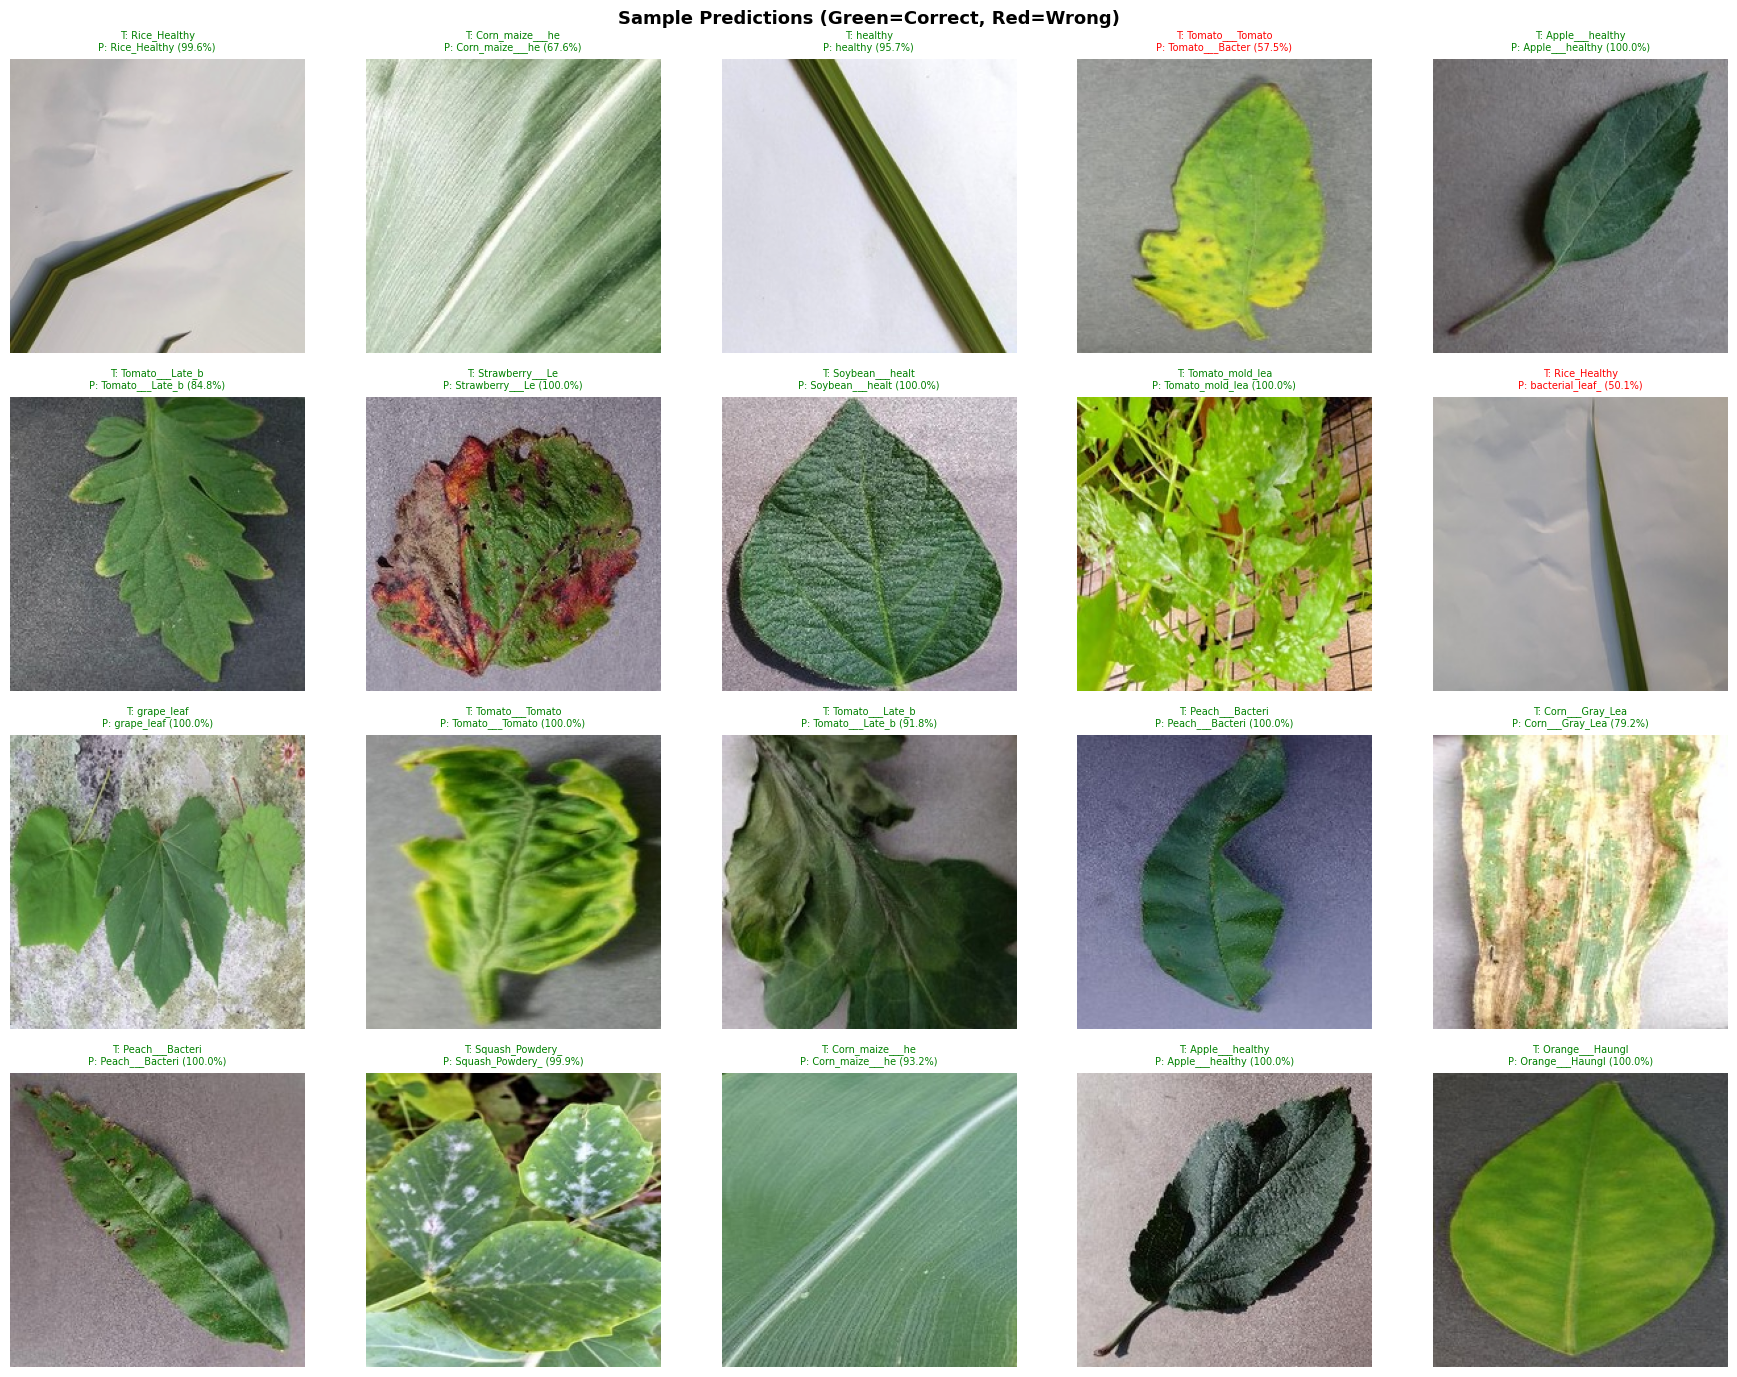

✅ Sample predictions saved!


In [8]:
# 20 random test images pe prediction dikhao
fig, axes = plt.subplots(4, 5, figsize=(18, 14))
axes = axes.flatten()

# Random samples lo
indices = np.random.choice(len(test_dataset), 20, replace=False)

for i, idx in enumerate(indices):
    img_tensor, true_label = test_dataset[idx]
    
    # Prediction
    with torch.no_grad():
        output   = model(img_tensor.unsqueeze(0).to(device))
        prob     = torch.softmax(output, dim=1)
        pred_idx = output.argmax(1).item()
        confidence = prob[0][pred_idx].item() * 100
    
    # Image display (denormalize)
    img_display = img_tensor.numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img_display = std * img_display + mean
    img_display = np.clip(img_display, 0, 1)
    
    true_name = class_names[true_label]
    pred_name = class_names[pred_idx]
    correct   = true_label == pred_idx
    
    axes[i].imshow(img_display)
    axes[i].set_title(
        f"T: {true_name[:15]}\nP: {pred_name[:15]} ({confidence:.1f}%)",
        fontsize=7,
        color='green' if correct else 'red'
    )
    axes[i].axis('off')

plt.suptitle(
    "Sample Predictions (Green=Correct, Red=Wrong)",
    fontsize=13, fontweight='bold'
)
plt.tight_layout()
plt.savefig("sample_predictions.png", dpi=150)
plt.show()

torch.cuda.empty_cache()
print("✅ Sample predictions saved!")


In [9]:
# Evaluation report save karo
eval_report = {
    "top1_accuracy"     : round(top1_acc, 2),
    "top5_accuracy"     : round(top5_acc, 2),
    "macro_avg_f1"      : round(report["macro avg"]["f1-score"] * 100, 2),
    "weighted_avg_f1"   : round(report["weighted avg"]["f1-score"] * 100, 2),
    "total_test_images" : len(all_labels),
    "num_classes"       : NUM_CLASSES,
    "best_class"        : sorted_f1[0][0],
    "best_class_f1"     : round(sorted_f1[0][1], 2),
    "worst_class"       : sorted_f1[-1][0],
    "worst_class_f1"    : round(sorted_f1[-1][1], 2),
}

with open(MODELS_DIR / "evaluation_report.json", "w") as f:
    json.dump(eval_report, f, indent=2)

print("=" * 55)
print("  KRISHISAT-AI — FINAL EVALUATION REPORT")
print("=" * 55)
print(f"  Top-1 Accuracy    : {eval_report['top1_accuracy']}%")
print(f"  Top-5 Accuracy    : {eval_report['top5_accuracy']}%")
print(f"  Macro Avg F1      : {eval_report['macro_avg_f1']}%")
print(f"  Weighted Avg F1   : {eval_report['weighted_avg_f1']}%")
print(f"  Test Images       : {eval_report['total_test_images']:,}")
print(f"  Classes           : {eval_report['num_classes']}")
print("-" * 55)
print(f"  Best Class  → {eval_report['best_class'][:30]}")
print(f"               F1: {eval_report['best_class_f1']}%")
print(f"  Worst Class → {eval_report['worst_class'][:30]}")
print(f"               F1: {eval_report['worst_class_f1']}%")
print("=" * 55)
print("\n  📁 Saved Files:")
print("     confusion_matrix.png")
print("     class_f1_scores.png")
print("     sample_predictions.png")
print("     evaluation_report.json")
print("\n  Next → Day 6: LSTM Forecasting Model")


  KRISHISAT-AI — FINAL EVALUATION REPORT
  Top-1 Accuracy    : 91.75%
  Top-5 Accuracy    : 99.66%
  Macro Avg F1      : 87.13%
  Weighted Avg F1   : 91.95%
  Test Images       : 7,742
  Classes           : 96
-------------------------------------------------------
  Best Class  → Apple___Cedar_apple_rust
               F1: 100.0%
  Worst Class → Wheat_Septoria
               F1: 41.38%

  📁 Saved Files:
     confusion_matrix.png
     class_f1_scores.png
     sample_predictions.png
     evaluation_report.json

  Next → Day 6: LSTM Forecasting Model
